### Setup

In [ ]:
# magic reload
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '..')
from analysis.analysis_utils import *
from utils.plot_utils import *
from datasets import load_dataset

ModuleNotFoundError: No module named 'utils.analysis_utils'

In [2]:
all_df = prepare_df()

### 2 vs 4 choice

In [3]:
verdict_ids_2_choice_gpqa =  ['o6nh196', 'se5tc1t', 'okcg9s1', 'px68tl7', 'gt5hbbc', 'omurjjz', '2ayhhpd', '7ir6j2d', 'mr8lipz', 'kn8lecm', 'k26y5y6', 'uopuf76', 'hmsolpd', 'wvubqq5', '0q341gz', 'm6zo8vx', 'jgrph0e']
verdict_ids_4_choice_gpqa =  ['2bmbqk1', 'po3v9oq', 'qx50tbo', 'jm9kod3', '4rg7b4b', 'faqmo5o', 'dph0qre', '9jiz6cv', 'p8zeu0p', 'ouuwuug', 'yt32eoi', 'vwmy4y3', 'qiqr2wo', '2pvnm1z', 'ujzubt9', '4ukh5h7', '3oxc0v3']

df_2_choice_gpqa = all_df[all_df['verdict_run_id_verdicts'].isin(verdict_ids_2_choice_gpqa)]
df_4_choice_gpqa = all_df[all_df['verdict_run_id_verdicts'].isin(verdict_ids_4_choice_gpqa)]

acc_2_choice_gpqa = aggregate_by_fields(df_2_choice_gpqa, ['config_judge_model_verdicts'])
acc_4_choice_gpqa = aggregate_by_fields(df_4_choice_gpqa, ['config_judge_model_verdicts'])

In [4]:
df_4_choice_gpqa[['config_judge_model_verdicts', 'verdict_run_id_verdicts']].value_counts()

config_judge_model_verdicts         verdict_run_id_verdicts
openai/gpt-4o-mini                  yt32eoi                    186
qwen/qwen-2.5-7b-instruct           qiqr2wo                    185
openai/gpt-3.5-turbo                ouuwuug                    185
google/gemma-3-27b-it               po3v9oq                    184
meta-llama/llama-3.1-405b-instruct  jm9kod3                    183
google/gemma-3-12b-it               2bmbqk1                    182
qwen/qwen-2.5-72b-instruct          vwmy4y3                    181
meta-llama/llama-3-8b-instruct      qx50tbo                    180
meta-llama/llama-3.3-70b-instruct   dph0qre                    177
meta-llama/llama-3.1-70b-instruct   4rg7b4b                    166
meta-llama/llama-3.1-8b-instruct    faqmo5o                    154
meta-llama/llama-4-scout            p8zeu0p                    153
meta-llama/llama-4-maverick         9jiz6cv                    149
qwen/qwen3-32b                      4ukh5h7                    126
qw

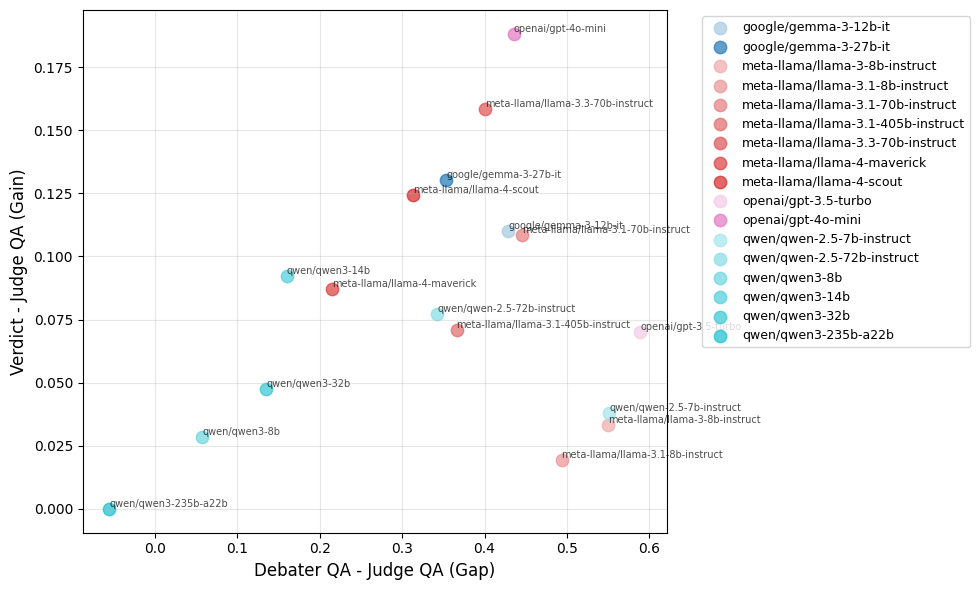

In [5]:
results_df = acc_4_choice_gpqa
# results_df = results_df[results_df['n_total'] > 45]
plot_gain_scatter(results_df, n_choices=4, over='gap') # or over=judge_qa

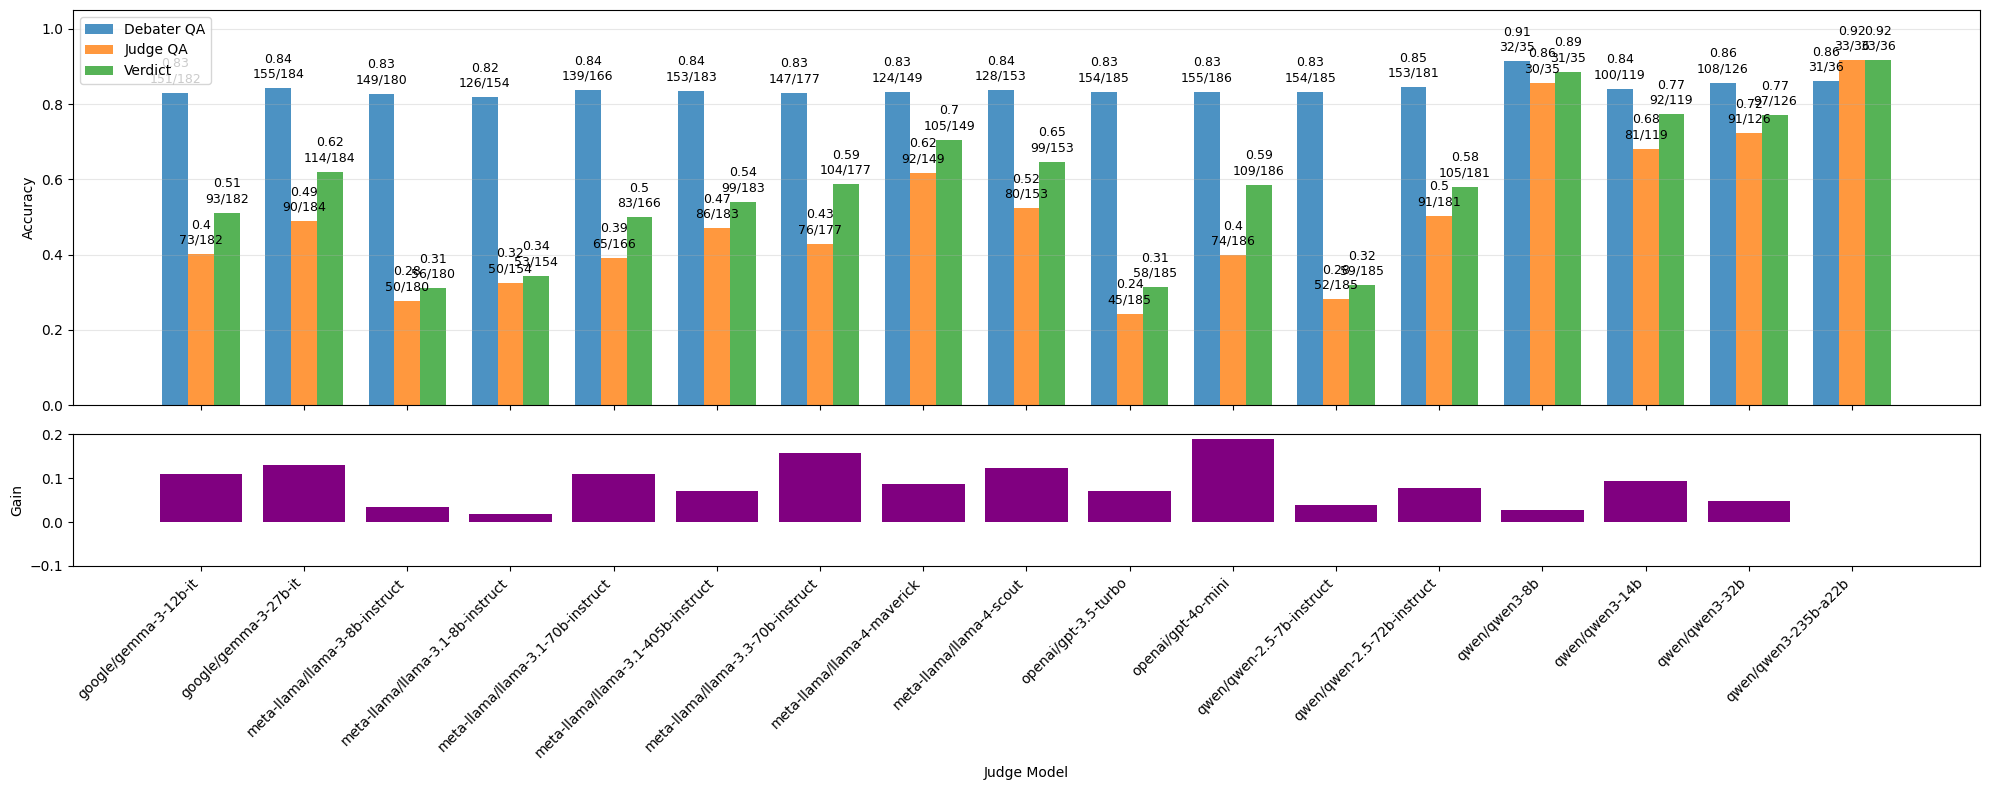

In [6]:
plot_results_by_name(acc_4_choice_gpqa)

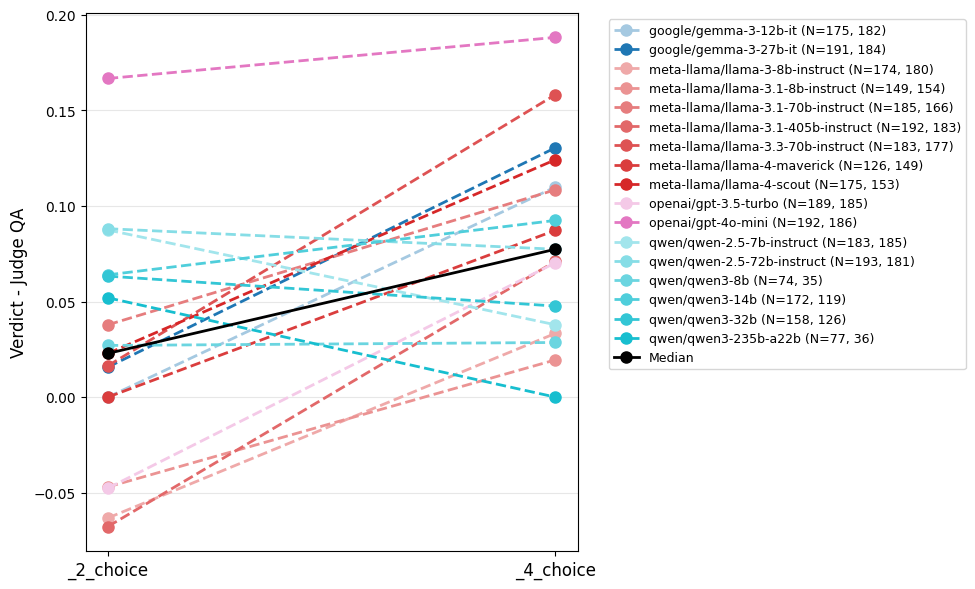

In [7]:
suffixes = ['_2_choice', '_4_choice']
merged_choice = acc_2_choice_gpqa.merge(acc_4_choice_gpqa, on='name', suffixes=suffixes)

plot_spaghetti(merged_choice, suffixes)

/Users/joshlevy/projects/llm_judge_debate_NEW/utils/plot_utils.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged['gap_delta'] = merged[f'gap{suffixes[0]}'] - merged[f'gap{suffixes[1]}']
/Users/joshlevy/projects/llm_judge_debate_NEW/utils/plot_utils.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged['gain_delta'] = merged[f'gain{suffixes[0]}'] - merged[f'gain{suffixes[1]}']
/Users/joshlevy/projects/llm_judge_debate_NEW/utils/plot_utils.py:139: SettingWithCopyWarning: 
A value is trying t

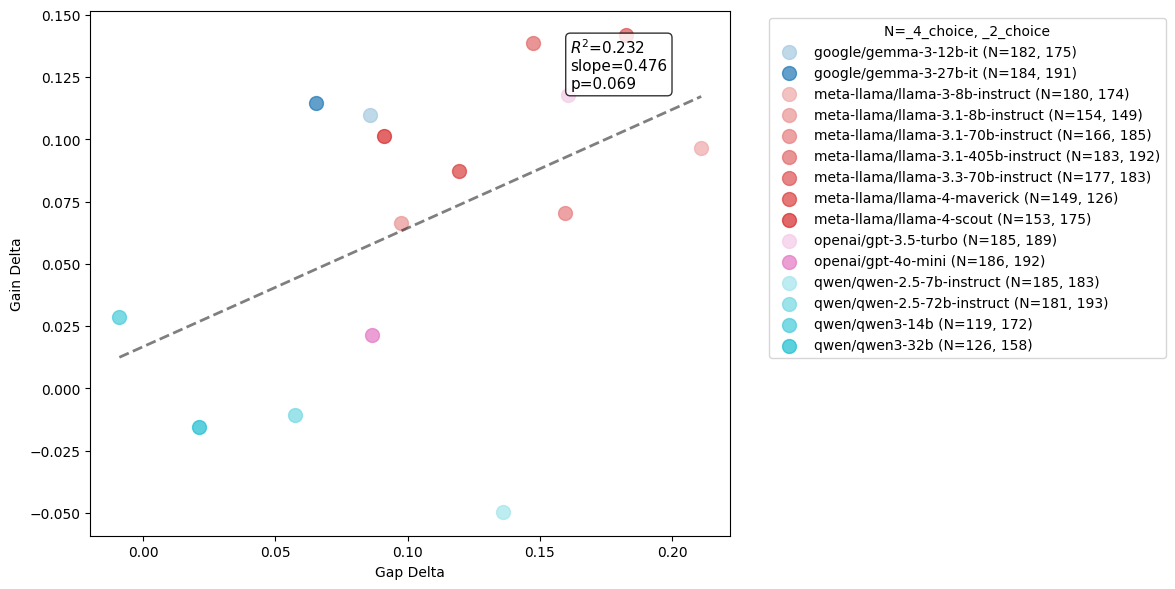

In [8]:
suffixes = ['_4_choice', '_2_choice']

temp = merged_choice[(merged_choice[f'n_total{suffixes[0]}'] > 45) & (merged_choice[f'n_total{suffixes[1]}'] > 45)]
plot_delta_over_delta(temp, suffixes, xfield='gap_delta', yfield='gain_delta', n_min=20)

### Breakdown by category

In [9]:
dataset = load_dataset('Idavidrein/gpqa', 'gpqa_diamond')['train']
dataset_df = dataset.to_pandas()
dataset_df = dataset_df.rename({'Question': 'question', 'High-level domain': 'high_level_domain'}, axis=1)

In [10]:
# temp_df = all_df.merge(dataset_df[['question', 'high_level_domain']], left_on=['question_verdicts'], right_on=['question'], how='left', suffixes=('', '_dataset'))
temp_df = df_4_choice_gpqa.merge(dataset_df[['question', 'high_level_domain']], left_on=['question_verdicts'], right_on=['question'], how='left', suffixes=('', '_dataset'))
# temp_df = df_2_choice_gpqa.merge(dataset_df[['question', 'high_level_domain']], left_on=['question_verdicts'], right_on=['question'], how='left', suffixes=('', '_dataset'))


chemistry_df = temp_df[temp_df['high_level_domain'] == 'Chemistry']
physics_df = temp_df[temp_df['high_level_domain'] == 'Physics']

chemistry_gpqa_acc = aggregate_by_fields(chemistry_df, ['config_judge_model_verdicts'])
physics_gpqa_acc = aggregate_by_fields(physics_df, ['config_judge_model_verdicts'])

/Users/joshlevy/projects/llm_judge_debate_NEW/utils/analysis_utils.py:146: RuntimeWarning: invalid value encountered in scalar divide
  'pgr': (group_df['is_correct_verdict'].mean() - group_df['is_correct_qa_judge'].mean()) / (group_df['is_correct_qa_debater'].mean() - group_df['is_correct_qa_judge'].mean()),


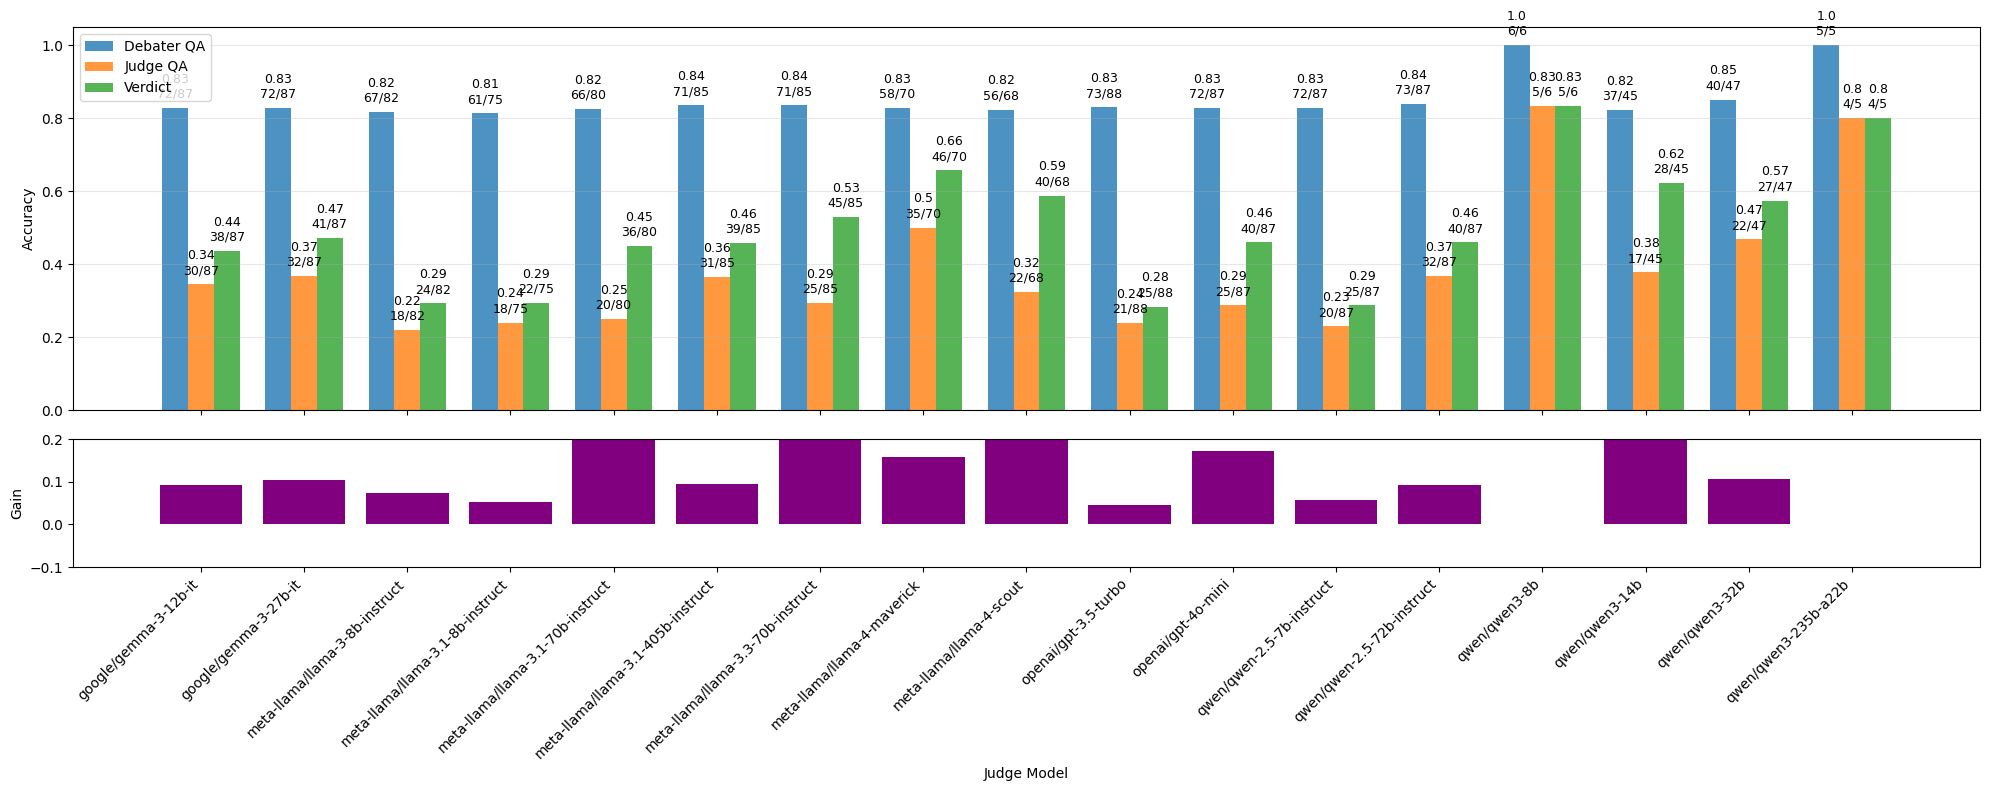

In [12]:
plot_results_by_name(chemistry_gpqa_acc)

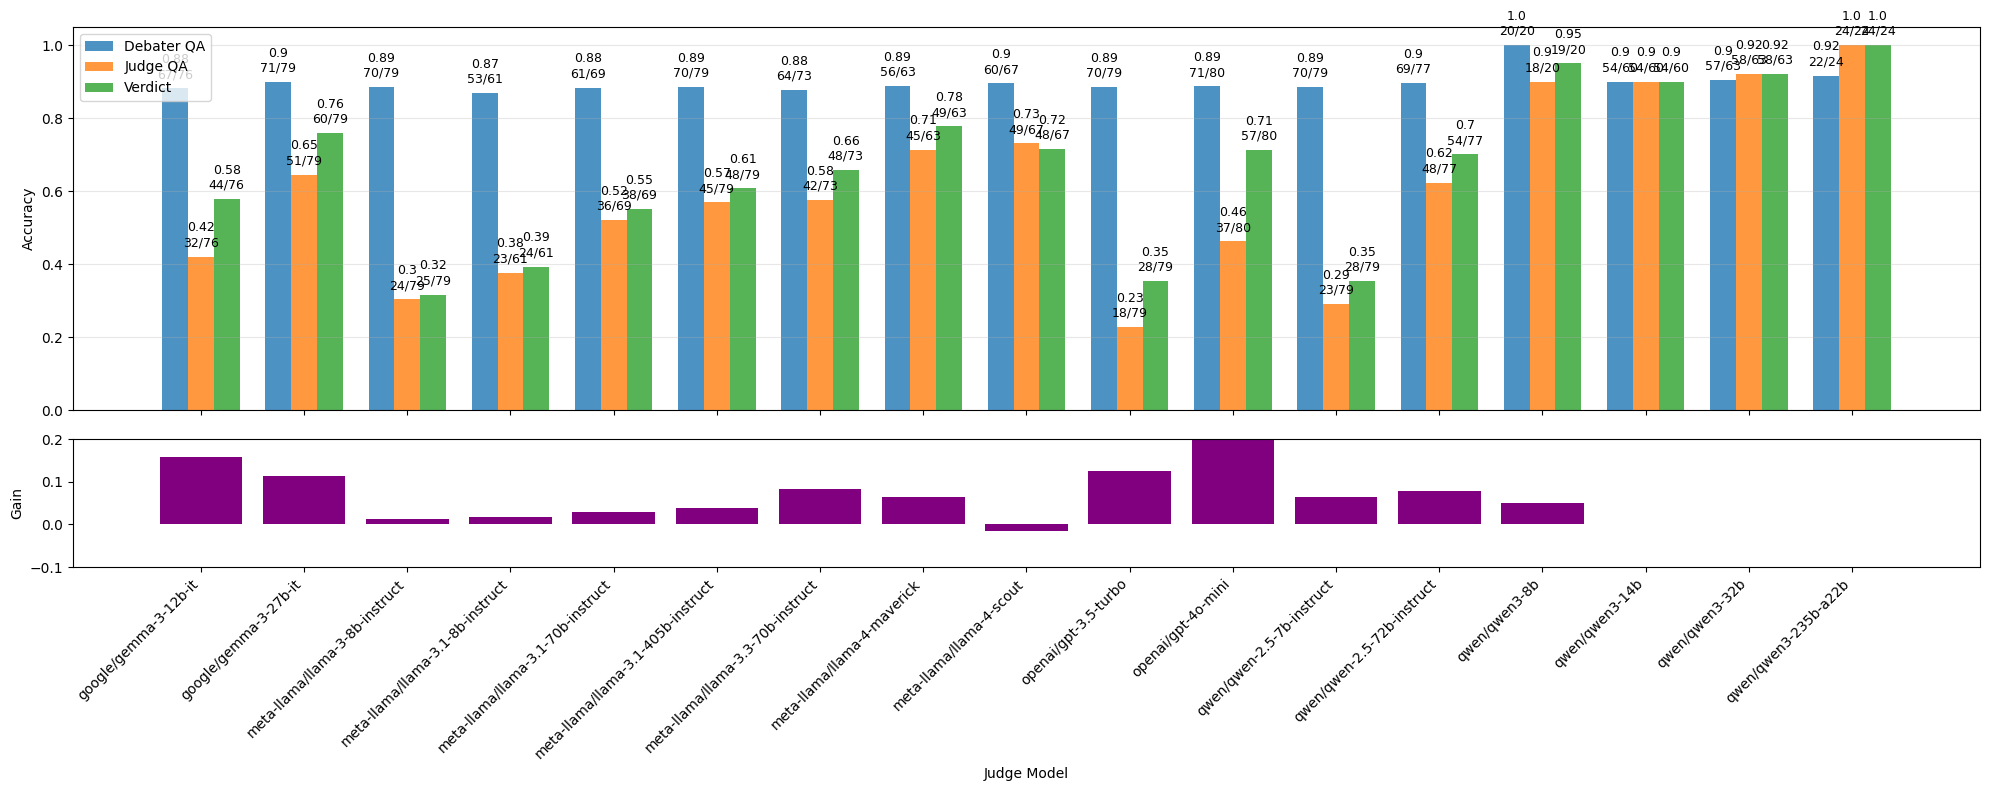

In [13]:
plot_results_by_name(physics_gpqa_acc)

skipping qwen/qwen3-8b because too few samples: n_0 = 6 and n_1 = 20
skipping qwen/qwen3-235b-a22b because too few samples: n_0 = 5 and n_1 = 24


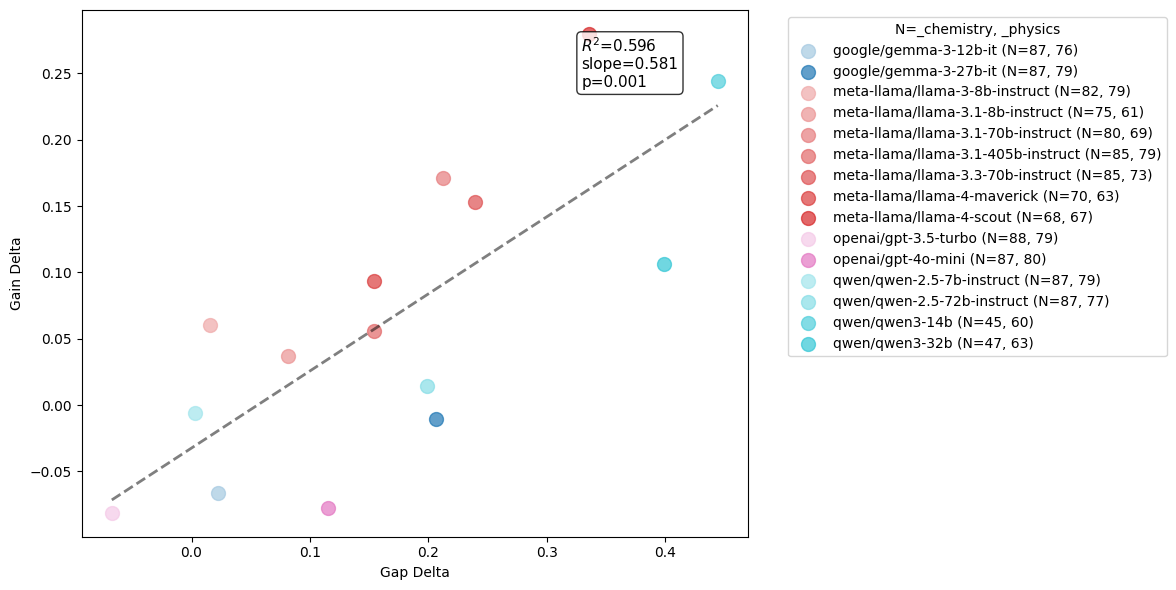

In [14]:
suffixes = ['_chemistry', '_physics']
merged_domains = chemistry_gpqa_acc.merge(physics_gpqa_acc, on='name', suffixes=suffixes)

plot_delta_over_delta(merged_domains, suffixes, xfield='gap_delta', yfield='gain_delta', n_min=20)